# Sample Model Evaluation Pipeline

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder

In [2]:
import cml.data_v1 as cmldata

CONNECTION_NAME = "default-hive"
conn = cmldata.get_connection(CONNECTION_NAME)

## Sample Usage to get pandas data frame
EXAMPLE_SQL_QUERY = "show databases"
dataframe = conn.get_pandas_dataframe(EXAMPLE_SQL_QUERY)
print(dataframe)

## Other Usage Notes:

## Alternate Sample Usage to provide different credentials as optional parameters
#conn = cmldata.get_connection(
#    CONNECTION_NAME, {"USERNAME": "someuser", "PASSWORD": "somepassword"}
#)

## Alternate Sample Usage to get DB API Connection interface
#db_conn = conn.get_base_connection()

## Alternate Sample Usage to get DB API Cursor interface
#db_cursor = conn.get_cursor()
#db_cursor.execute(EXAMPLE_SQL_QUERY)
#for row in db_cursor:
#  print(row)

         database_name
0          01_car_data
1            01_car_dw
2           airline_dw
3             airlines
4         airlines_csv
5     airlines_iceberg
6             bankdemo
7               bhagan
8              cdedemo
9         cdp_overview
10          creditrisk
11                dbgr
12             default
13              glivni
14  information_schema
15        pdf_car_data
16       prescribing_p
17     prescribing_p_e
18          retaildemo
19                 sys
20         ukcrime_dev
21           ukweather


In [3]:
EXAMPLE_SQL_QUERY = "select *\
                    from default.marketing_campaign_table as m\
                    inner join default.bank_info_table as b\
                    on m.name = b.name"

df = conn.get_pandas_dataframe(EXAMPLE_SQL_QUERY)

#### Why not load the dataframes into Pandas and join via Pandas SQL? The query is running in Hive, achieving dramatically higher scalability

In [4]:
df.head()

,m.name,m.street_address,m.city,m.postcode,m.phone_number,m.job,b.name,b.aba_routing,b.bank_country,b.account_number,...,b.recency,b.history,b.used_discount,b.used_bogo,b.zip_code,b.is_referral,b.channel,b.offer,b.conversion,b.score
0,Ryan Perez,f5f204d8428d91eed873d5ea6dfb43fc3cc259948b43c0...,Johnsonland,91012,(317)017-1943,Dentist,Ryan Perez,010256103,GB,TWYL69320475066538,...,2,45.34,1,0,Urban,0,Web,Buy One Get One,0,0.5250908284092843
1,Jason Rodriguez,028bb2957884eb13b82ced5c694601849d3af842107b56...,South Craighaven,48410,282.765.5153x11565,Senior tax professional/tax inspector,Jason Rodriguez,106412929,GB,FZTV56775417147533,...,9,280.2,1,0,Surburban,1,Phone,Buy One Get One,0,0.919413935288077
2,Leah Miller,4208ed7d3b6499f8016061e4917064a2167f6bdbb26aa8...,Alicefurt,80189,555-555-6116x076,"""Programmer",Leah Miller,010489378,GB,JNDG16711629611689,...,9,46.42,0,1,Urban,0,Phone,Buy One Get One,0,1.4776779062404213
3,Kelly Grimes,d72f1599d46ab4f2dcb09219561e6ce1c65e40ea49792b...,New Willieside,05486,514-001-2127x18401,Contracting civil engineer,Kelly Grimes,054032464,GB,UQPK98310055923994,...,2,101.64,0,1,Urban,0,Web,Discount,1,1.2284264634346713
4,Tiffany Walker,0981d45305ad008ef413ebfec37ce01cfa247cc68a5ea0...,Tabithahaven,86090,136.311.5880,Hotel manager,Tiffany Walker,041013959,GB,EIRT74629944855089,...,4,241.42,0,1,Rural,1,Multichannel,No Offer,0,1.1863879409505733


In [5]:
df.dtypes

m.name              object
m.street_address    object
m.city              object
m.postcode          object
m.phone_number      object
m.job               object
b.name              object
b.aba_routing       object
b.bank_country      object
b.account_number    object
b.iban              object
b.swift11           object
b.recency           object
b.history           object
b.used_discount     object
b.used_bogo         object
b.zip_code          object
b.is_referral       object
b.channel           object
b.offer             object
b.conversion        object
b.score             object
dtype: object

In [6]:
df = df.iloc[1:]

In [7]:
df.describe()

,m.name,m.street_address,m.city,m.postcode,m.phone_number,m.job,b.name,b.aba_routing,b.bank_country,b.account_number,...,b.recency,b.history,b.used_discount,b.used_bogo,b.zip_code,b.is_referral,b.channel,b.offer,b.conversion,b.score
count,254,254,254,254,254,254,254,254,254,254,...,254,254,254,254,254,254,254,254,254,254
unique,245,248,248,248,248,176,245,245,1,245,...,12,221,2,2,3,2,3,3,2,248
top,Kimberly Johnson,bffb3bc580d4e9a3c7e63a61e9a971a8cef0f81e57c0e0...,South Davidhaven,21018,(078)835-0206x721,"""Psychologist",Kimberly Johnson,072334487,GB,HYQZ35368615661276,...,3,29.99,1,1,Surburban,1,Web,Buy One Get One,0,1.135306175661745
freq,4,2,2,2,2,9,4,4,254,4,...,30,29,148,129,102,132,119,102,220,2


In [8]:
baseline_df = df[["m.job","b.recency", "b.used_discount", "b.used_bogo", "b.zip_code", "b.is_referral", "b.channel", "b.offer", "b.score", "b.conversion"]] 

In [9]:
baseline_df = baseline_df.astype({"m.job":"string", 
                                  "b.recency":"int64", 
                                  "b.used_discount":"int64", 
                                  "b.used_bogo":"int64",
                                  "b.zip_code":"string", 
                                  "b.is_referral":"int64", 
                                  "b.channel":"string", 
                                  "b.offer":"string", 
                                  "b.score":"float64",
                                  "b.conversion":"int64"})

In [10]:
baseline_df.head()

,m.job,b.recency,b.used_discount,b.used_bogo,b.zip_code,b.is_referral,b.channel,b.offer,b.score,b.conversion
1,Senior tax professional/tax inspector,9,1,0,Surburban,1,Phone,Buy One Get One,0.919414,0
2,"""Programmer",9,0,1,Urban,0,Phone,Buy One Get One,1.477678,0
3,Contracting civil engineer,2,0,1,Urban,0,Web,Discount,1.228426,1
4,Hotel manager,4,0,1,Rural,1,Multichannel,No Offer,1.186388,0
5,"""Investment banker",3,1,0,Urban,1,Web,No Offer,2.243689,1


In [11]:
baseline_df.dtypes

m.job               string
b.recency            int64
b.used_discount      int64
b.used_bogo          int64
b.zip_code          string
b.is_referral        int64
b.channel           string
b.offer             string
b.score            float64
b.conversion         int64
dtype: object

##### Simple Data Viz

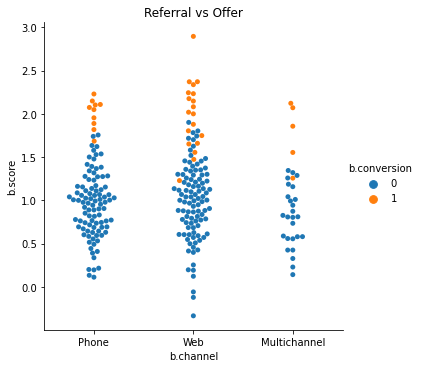

In [12]:
sns.catplot(x="b.channel", y="b.score", hue="b.conversion", kind="swarm", data=baseline_df).set(title='Referral vs Offer')
plt.show()

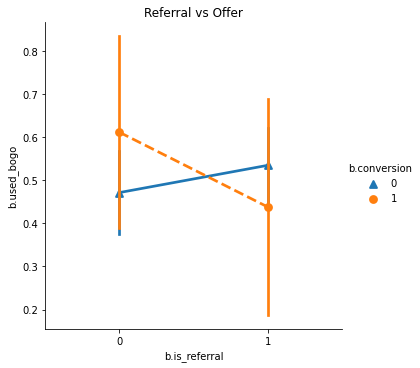

In [13]:
sns.catplot(x="b.is_referral", y="b.used_bogo", hue="b.conversion",
            markers=["^", "o"], linestyles=["-", "--"],
            kind="point", data=baseline_df).set(title='Referral vs Offer')
plt.show()

##### Investigating Target Class Imbalance

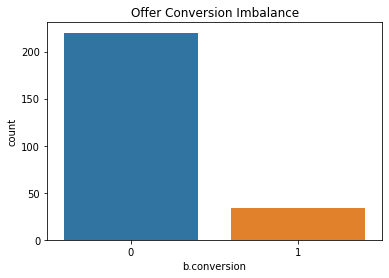

In [14]:
sns.countplot(x="b.conversion", data=df).set(title='Offer Conversion Imbalance')
plt.show()

Building a Model Evaluation Pipeline

In [15]:
#Split data between training and test sets
def split_data(df, target_name, test_size):
    
    y = df[target_name]
    X = df.drop(target_name, axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state = 1)

    return X_train, X_test, y_train, y_test

In [16]:
def create_pipeline(clf):
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', RobustScaler())])
    
    cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))])

    preprocessor = ColumnTransformer(
        transformers=[('num', numeric_transformer, numeric_features),
                      ('cat', cat_transformer, cat_features),], remainder='passthrough')
    
    clf_name = type(clf).__name__

    # Append classifier to preprocessing pipeline.
    pipe = Pipeline(steps=[('preprocessor', preprocessor),(clf_name, clf)])

    return pipe

In [17]:
def test_model(clfs, df, y_name, scoring_metric):
    
    X_train, X_test, y_train, y_test = split_data(df, y_name, 0.33)
    
    cv_results = {}
    test_results = {}
    best_estimators = {}
    
    #Iterate through each model:
    for clf in clfs.items():
        
        pipe = create_pipeline(clf[0])
    
        gs = GridSearchCV(pipe, param_grid=clf[1], cv=5, scoring=scoring_metric, n_jobs=-1)
        
        gs.fit(X_train,y_train)
        
        cv_metric = cross_val_score(gs, X_train, y_train, cv=3)
        
        test_score = gs.score(X_test, y_test)
        
        best_estimators[type(clf[0]).__name__] = gs.best_estimator_
        
        cv_results[type(clf[0]).__name__] = cv_metric
        
        test_results[type(clf[0]).__name__] = test_score
    
    return cv_results, test_results, best_estimators

In [18]:
clfs = {
        AdaBoostClassifier(DecisionTreeClassifier(max_depth = 5, max_features=10, class_weight='balanced'))
                                            :{
                                            'AdaBoostClassifier__learning_rate':[0.6, 0.9],
                                            'AdaBoostClassifier__n_estimators':[10]},
        
        RandomForestClassifier():{
                                            'RandomForestClassifier__max_depth':[10], 
                                            'RandomForestClassifier__min_samples_leaf':[20000],
                                            'RandomForestClassifier__min_samples_split':[10000], 
                                            'RandomForestClassifier__class_weight':['balanced'], 
                                            'RandomForestClassifier__n_estimators':[10]}
        }

In [19]:
X_train, X_test, y_train, y_test = split_data(baseline_df, 'b.conversion', 0.3)

In [20]:
numeric_features = list(baseline_df.select_dtypes(include=['int', 'float']).columns)
numeric_features.remove('b.conversion')

In [21]:
cat_features = list(baseline_df.select_dtypes(exclude=['int', 'float']).columns)
#cat_features.remove('b.conversion')

In [22]:
#cat_features + numeric_features

In [23]:
cv_results, test_results, best_estimators = test_model(clfs, baseline_df, 'b.conversion', 'accuracy')

In [24]:
#Simple visualization of outcomes:
def visualize_results(results):
    
    res = pd.DataFrame(results).round(4)
    
    fig, ax1 = plt.subplots(figsize=(len(res.columns)*3,4))
    sns.boxplot(data=res, ax=ax1)
    plt.suptitle('Model Evaluation Report')
    plt.show()

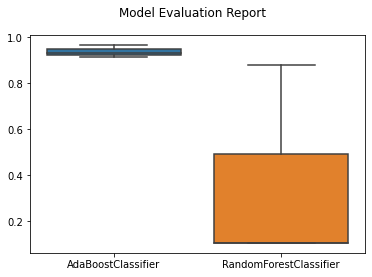

In [25]:
visualize_results(cv_results)

In [26]:
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import ClassificationReport, PrecisionRecallCurve, ConfusionMatrix

In [27]:
def conf_matrix(clf, X_train, X_test, y_train, y_test):
    fig, ax = plt.subplots(figsize=(8,5))

    cm = ConfusionMatrix(clf, classes=[0,1], ax=ax)
    cm.fit(X_train, y_train)
    cm.score(X_test, y_test)

    ax.set(title='GBM Confusion Matrix', xlabel='Predicted Class', ylabel='True Class')

    cm.poof()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


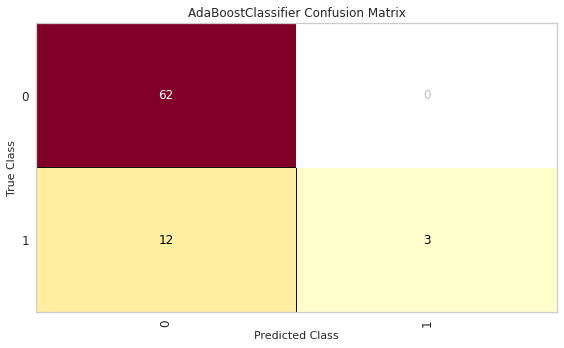

In [28]:
conf_matrix(best_estimators['AdaBoostClassifier'], X_train, X_test, y_train, y_test)

In [29]:
def val_curves(clf, param_name, param_range, cv, X_train, y_train, scoring):

    fig, ax = plt.subplots(figsize=(8,4))

    viz_vc_bg = ValidationCurve(
                    clf, param_name=param_name,
                    param_range=param_range, cv=cv, 
                    scoring=scoring, ax=ax)

    viz_vc_bg.fit(X_train, y_train)
    
    clf_name = type(clf).__name__
    title = "Validation Curves for: {}".format(clf_name)
    
    ax.set(title=title, ylabel='Score')
    ax.legend().set_visible(True)

    viz_vc_bg.poof()

In [30]:
def learn_curves(clf, cv, X_train, y_train, scoring):

    fig, ax = plt.subplots(figsize=(8,4))

    viz_lc_bg = LearningCurve(clf, train_sizes = np.linspace(0.1, 1.0, 10), 
                              scoring=scoring, cv=cv, ax=ax)

    # Fit and poof the visualizer
    viz_lc_bg.fit(X_train, y_train)

    ax.set(title='Learning Curves', xlabel='Training Instances', ylabel='Score')

    ax.legend().set_visible(True)

    viz_lc_bg.poof()

/home/cdsw/.local/lib/python3.7/site-packages/sklearn/ensemble/_weight_boosting.py:607: RuntimeWarning: overflow encountered in exp
  estimator_weight * ((sample_weight > 0) | (estimator_weight < 0))
/home/cdsw/.local/lib/python3.7/site-packages/sklearn/ensemble/_weight_boosting.py:486: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/home/cdsw/.local/lib/python3.7/site-packages/sklearn/ensemble/_weight_boosting.py:607: RuntimeWarning: overflow encountered in exp
  estimator_weight * ((sample_weight > 0) | (estimator_weight < 0))
/home/cdsw/.local/lib/python3.7/site-packages/sklearn/ensemble/_weight_boosting.py:486: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
findfont: Font family ['sans-serif'] not found. Fall

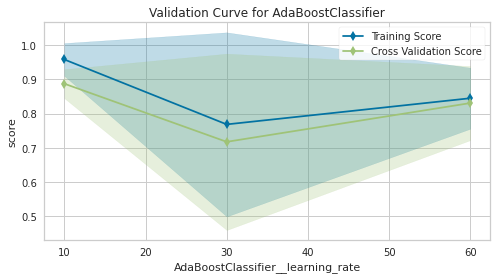

In [31]:
val_curves(best_estimators['AdaBoostClassifier'], 
           'AdaBoostClassifier__learning_rate', [10, 30, 60], 3, X_train, y_train, 'accuracy')

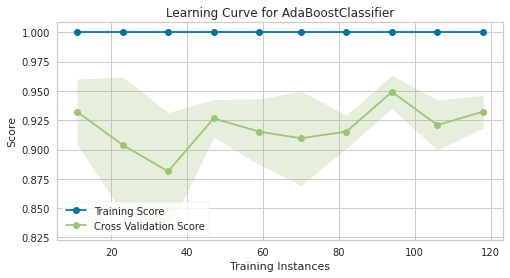

In [32]:
learn_curves(best_estimators['AdaBoostClassifier'], 3, X_train, y_train, 'accuracy')

In [33]:
import pickle

In [34]:
filename = 'models/adaboost.joblib'
pickle.dump(best_estimators['AdaBoostClassifier'], open(filename, 'wb'))